In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
n_epoch = 300
batch_size = 16
lr = 4e-5
betas = (0.9, 0.999)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)

# Fit the MinMaxScalar for output data
output_for_Scalar = np.load("Data/Geoid/1k/output.npy")
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(output_for_Scalar)
print("Fit the output range to [0,1] using MinMaxscaler")

'''
# Fit another MinMaxScalar for input data
input_for_Scalar = np.load("Data/Geoid/1k/input.npy")
scaler_input = MinMaxScaler()
#scaler = StandardScaler()
scaler_input.fit(input_for_Scalar)
print("Fit the input range to [0,1] using MinMaxscaler")
'''

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler


In [3]:
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = np.load(input_path)
        output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [4]:
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset
geoid_dataset = KMNIST(
    "Data/Geoid/1k/input.npy",
    "Data/Geoid/1k/output.npy",
)

# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)
geoid_valid_sampler = SubsetRandomSampler(geoid_val_indices)

geoid_train_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)

geoid_validation_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_valid_sampler,
)

print("Training data, testing data and validation data is spilt into 8:1:1")

Training data, testing data and validation data is spilt into 8:1:1


In [5]:
'''
train_input, train_output = next(iter(geoid_train_loader))

print(f"Feature batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_output.size()}")

test_index = 1
train_input_batch_sample = train_input[test_index]
train_output_batch_sample = train_output[test_index]

print(f"Input: {train_input_batch_sample}")
print(f"Output: {train_output_batch_sample}")
'''

'\ntrain_input, train_output = next(iter(geoid_train_loader))\n\nprint(f"Feature batch shape: {train_input.size()}")\nprint(f"Labels batch shape: {train_output.size()}")\n\ntest_index = 1\ntrain_input_batch_sample = train_input[test_index]\ntrain_output_batch_sample = train_output[test_index]\n\nprint(f"Input: {train_input_batch_sample}")\nprint(f"Output: {train_output_batch_sample}")\n'

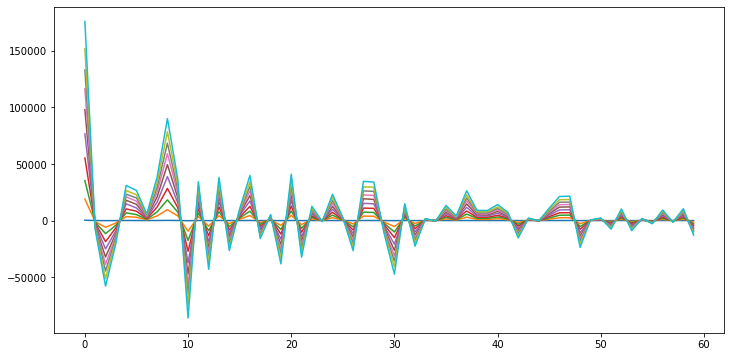

In [6]:
voutput = np.load("Data/Geoid/1k/output.npy")

nmodels, _ = voutput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model output and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(voutput[i, :])

plt.show()

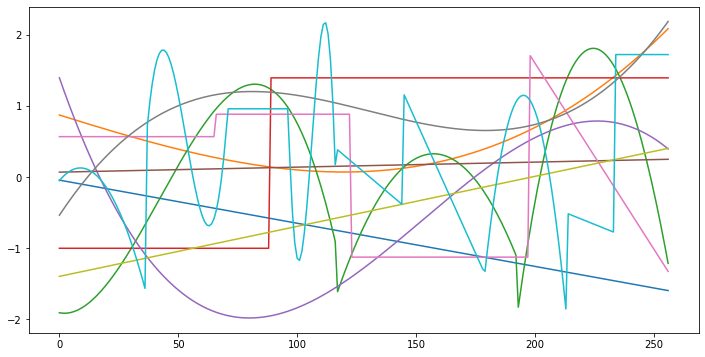

In [7]:
vinput = np.load("Data/Geoid/1k/input.npy")

nmodels, _ = vinput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model input and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(vinput[i, :])

plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.fc1 = nn.Linear(257, 200)  
        self.fc2 = nn.Linear(200, 150)   
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, 60)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
    
    def forward(self, x):                              
        x = x.to(torch.float32)
        
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        return out

In [9]:
def train(model, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # Get output features and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than 0.02, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= 0.02:
                        correct += 1
                    total += 1

                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models
        
            PATH = 'geoid_model_best.pth'

            torch.save(model.state_dict(), PATH)
            print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Finished Training')
    print("Best model has a validation loss of ",minimum_validation_loss)
    print("Best model is in epoch ",best_model_index+1)
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)

    plt.show()

In [10]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

1 epochs have finished
Current training loss is  16.486284852027893
Validation loss for this epoch is 2.139904952286611
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

2 epochs have finished
Current training loss is  13.898141726851463
Validation loss for this epoch is 1.7271907374855067
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

3 epochs have finished
Current training loss is  10.140331879258156
Validation loss for this epoch is 1.1678913720942765
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

4 epochs have finished
Current training loss is  7.225647643208504
Validation loss for this epoch is 0.8701977560842113
Validation Accuracy for this epoch is 3
This model is now saved to Path: geoid_model_best.pth

5 epochs have finished
Current training loss is  5.854409493505955
Validation loss for this epoch is 0.8461869607681161
Validation Accurac

47 epochs have finished
Current training loss is  3.6320942752063274
Validation loss for this epoch is 0.5569363291333902
Validation Accuracy for this epoch is 24
This model is now saved to Path: geoid_model_best.pth

48 epochs have finished
Current training loss is  3.582284539937973
Validation loss for this epoch is 0.6067317427594018
Validation Accuracy for this epoch is 21

49 epochs have finished
Current training loss is  3.52860613912344
Validation loss for this epoch is 0.6328059739284283
Validation Accuracy for this epoch is 25

50 epochs have finished
Current training loss is  3.4787056371569633
Validation loss for this epoch is 0.5573516509120823
Validation Accuracy for this epoch is 24

51 epochs have finished
Current training loss is  3.413408540189266
Validation loss for this epoch is 0.6083316756299187
Validation Accuracy for this epoch is 21

52 epochs have finished
Current training loss is  3.3571104258298874
Validation loss for this epoch is 0.5875707251733746
Validati

98 epochs have finished
Current training loss is  1.8917119447141886
Validation loss for this epoch is 0.7134220745336849
Validation Accuracy for this epoch is 31

99 epochs have finished
Current training loss is  1.8492092154920101
Validation loss for this epoch is 0.7092072411191901
Validation Accuracy for this epoch is 31

100 epochs have finished
Current training loss is  1.8444210225716233
Validation loss for this epoch is 0.7384650387484489
Validation Accuracy for this epoch is 30

101 epochs have finished
Current training loss is  1.8251734552904963
Validation loss for this epoch is 0.7555488055646811
Validation Accuracy for this epoch is 31

102 epochs have finished
Current training loss is  1.8726151175796986
Validation loss for this epoch is 0.711495443839587
Validation Accuracy for this epoch is 31

103 epochs have finished
Current training loss is  1.8385485475882888
Validation loss for this epoch is 0.732320145441622
Validation Accuracy for this epoch is 24

104 epochs hav

148 epochs have finished
Current training loss is  1.4970162576064467
Validation loss for this epoch is 0.87343906430689
Validation Accuracy for this epoch is 29

149 epochs have finished
Current training loss is  1.4339183252304792
Validation loss for this epoch is 0.77598906169518
Validation Accuracy for this epoch is 25

150 epochs have finished
Current training loss is  1.5147684561088681
Validation loss for this epoch is 0.7570418784199773
Validation Accuracy for this epoch is 27

151 epochs have finished
Current training loss is  1.4849657770246267
Validation loss for this epoch is 0.7375578465857625
Validation Accuracy for this epoch is 29

152 epochs have finished
Current training loss is  1.4419133863411844
Validation loss for this epoch is 0.7725707243538493
Validation Accuracy for this epoch is 30

153 epochs have finished
Current training loss is  1.4582202546298504
Validation loss for this epoch is 0.7452195188475077
Validation Accuracy for this epoch is 27

154 epochs hav

198 epochs have finished
Current training loss is  1.2947856045793742
Validation loss for this epoch is 0.8058599135505738
Validation Accuracy for this epoch is 30

199 epochs have finished
Current training loss is  1.283286021091044
Validation loss for this epoch is 0.8505504479969848
Validation Accuracy for this epoch is 26

200 epochs have finished
Current training loss is  1.328599603381008
Validation loss for this epoch is 0.7764122427478788
Validation Accuracy for this epoch is 28

201 epochs have finished
Current training loss is  1.2752873934805393
Validation loss for this epoch is 0.778105070391095
Validation Accuracy for this epoch is 27

202 epochs have finished
Current training loss is  1.2969869286753237
Validation loss for this epoch is 0.8740562169574678
Validation Accuracy for this epoch is 28

203 epochs have finished
Current training loss is  1.2891572806984186
Validation loss for this epoch is 1.0407479249191374
Validation Accuracy for this epoch is 26

204 epochs ha

248 epochs have finished
Current training loss is  1.221642104908824
Validation loss for this epoch is 0.8031495615362323
Validation Accuracy for this epoch is 27

249 epochs have finished
Current training loss is  1.2304489174857736
Validation loss for this epoch is 1.1629816672443885
Validation Accuracy for this epoch is 23

250 epochs have finished
Current training loss is  1.217952260747552
Validation loss for this epoch is 0.8940919250741193
Validation Accuracy for this epoch is 27

251 epochs have finished
Current training loss is  1.1942386184819043
Validation loss for this epoch is 0.8864979064522902
Validation Accuracy for this epoch is 30

252 epochs have finished
Current training loss is  1.1834412687458098
Validation loss for this epoch is 0.8060279263573997
Validation Accuracy for this epoch is 28

253 epochs have finished
Current training loss is  1.1834917564410716
Validation loss for this epoch is 0.8498057762250425
Validation Accuracy for this epoch is 30

254 epochs h

298 epochs have finished
Current training loss is  1.1298574358224869
Validation loss for this epoch is 0.8376629398149804
Validation Accuracy for this epoch is 28

299 epochs have finished
Current training loss is  1.1175382428336889
Validation loss for this epoch is 0.8177954137460236
Validation Accuracy for this epoch is 28

300 epochs have finished
Current training loss is  1.1152047025971115
Validation loss for this epoch is 0.9460487995038992
Validation Accuracy for this epoch is 31

Finished Training
Best model has a validation loss of  0.5511681098800796
Best model is in epoch  56


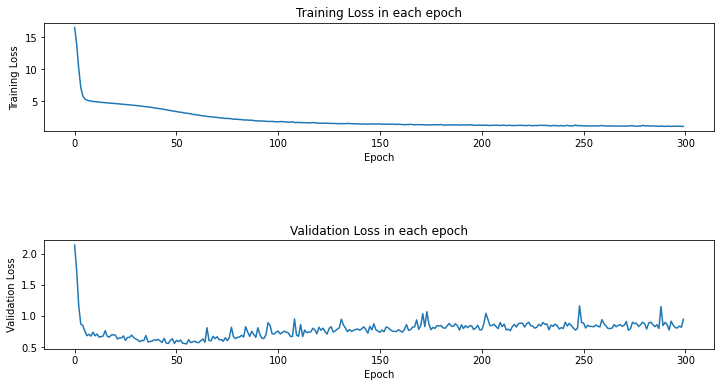

In [11]:
train(model, geoid_train_loader, geoid_validation_loader, device, optimizer, n_epoch)

In [12]:
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than 0.02, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                if single_loss.item() <= 0.02:
                    correct += 1
                total += 1

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    return 100*correct//total, total_loss

In [13]:
# Print Accuracy for the training data using the current model (Not the best one)
test(model, geoid_train_loader, device)

Total loss for the model is 1.079704745536969
Accuracy for the model is 78


(78, 1.079704745536969)

In [14]:
# Print Accuracy for the Testing data using the current model (Not the best one)
test(model, geoid_test_loader, device)

Total loss for the model is 0.7877563913826189
Accuracy for the model is 35


(35, 0.7877563913826189)

In [15]:
# Print Accuracy for the training data using the best one
model.load_state_dict(torch.load('geoid_model_best.pth'))
test(model, geoid_train_loader, device)

Total loss for the model is 3.0550786567648838
Accuracy for the model is 36


(36, 3.0550786567648838)

In [16]:
# Print Accuracy for the Testing data using the current model (Not the best one)
test(model, geoid_test_loader, device)

Total loss for the model is 0.6303373651315765
Accuracy for the model is 31


(31, 0.6303373651315765)

Loss between predicted output and actual output (Both Normalised) 0.0396119443927


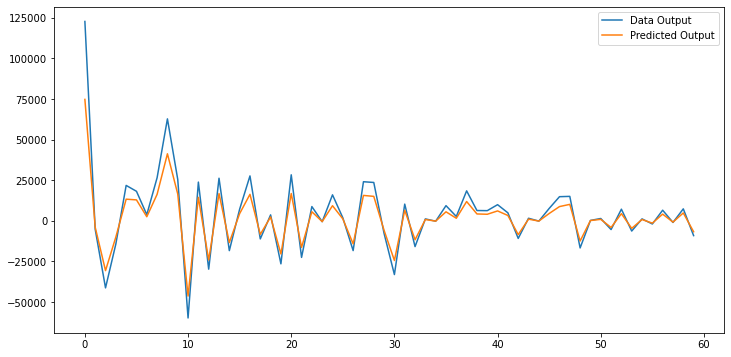

Loss between predicted output and actual output (Both Normalised) 0.05165538723282153


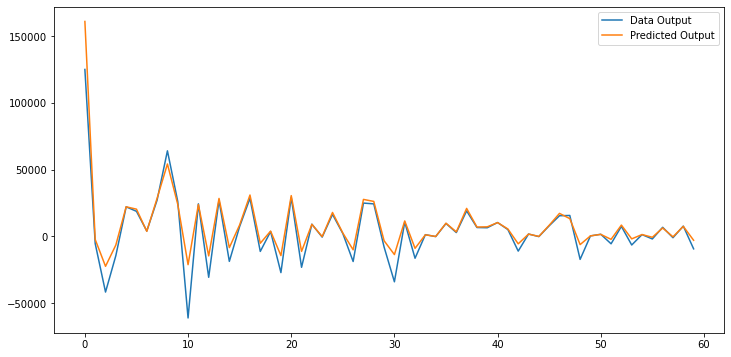

Loss between predicted output and actual output (Both Normalised) 0.0023284920190103668


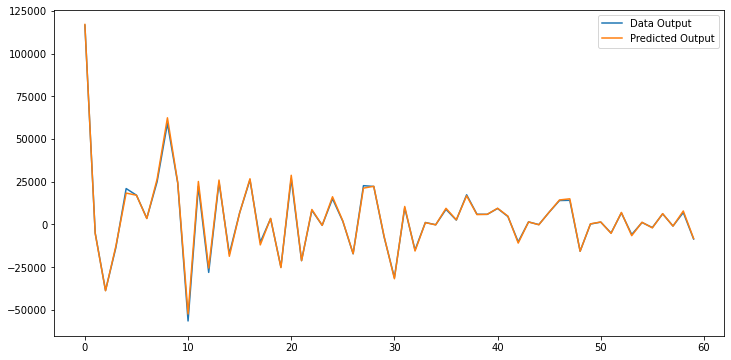

Loss between predicted output and actual output (Both Normalised) 0.002429919796951699


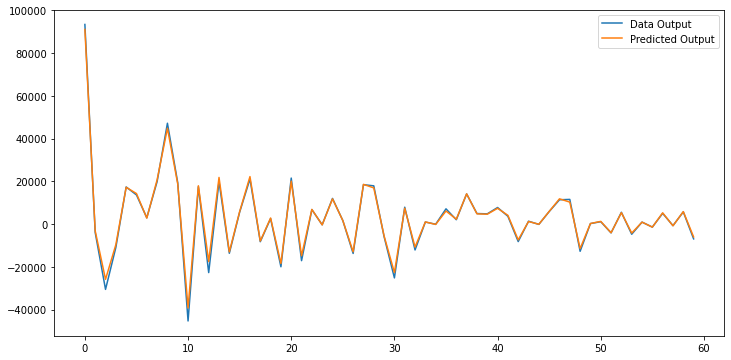

Loss between predicted output and actual output (Both Normalised) 0.19911908360938438


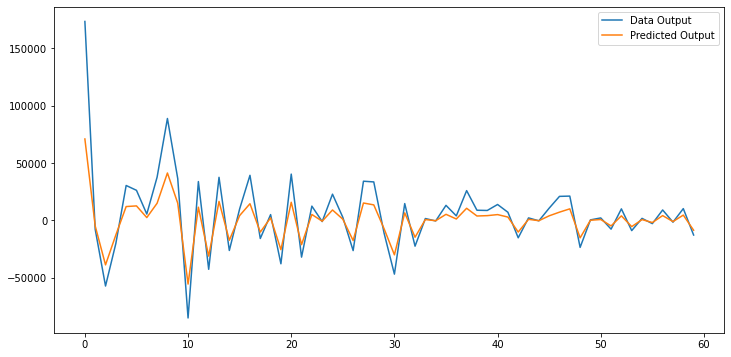

Loss between predicted output and actual output (Both Normalised) 0.08104438030524953


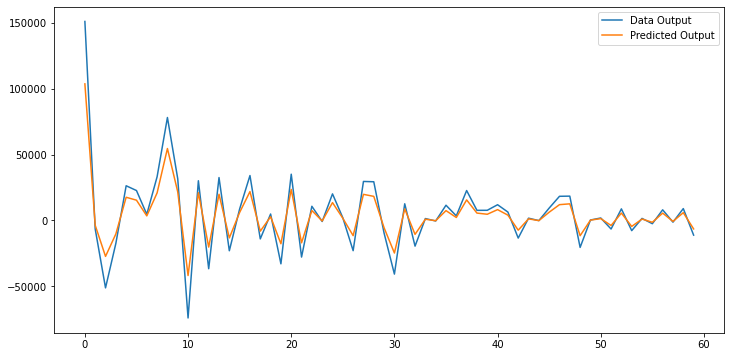

Loss between predicted output and actual output (Both Normalised) 0.1965382648243416


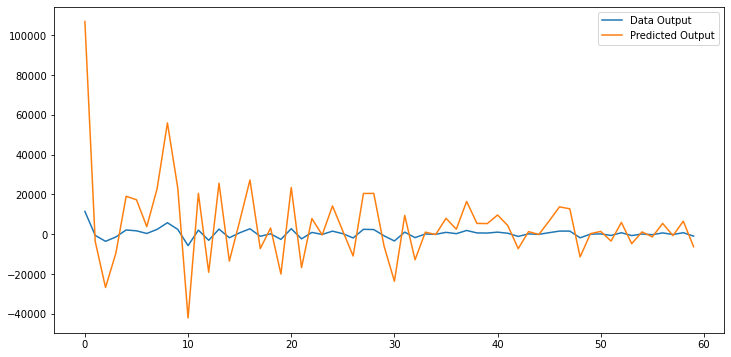

Loss between predicted output and actual output (Both Normalised) 0.0336505206093967


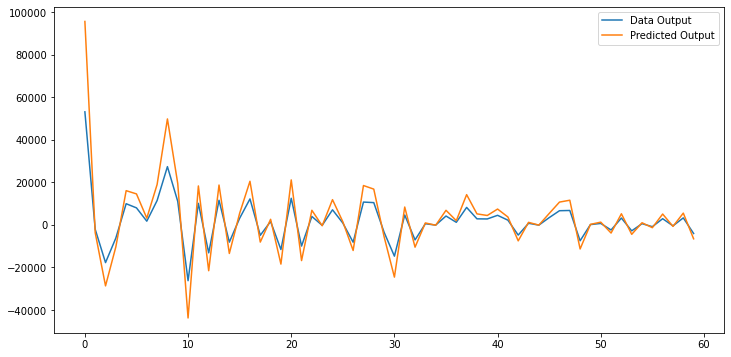

Loss between predicted output and actual output (Both Normalised) 0.14926866277607562


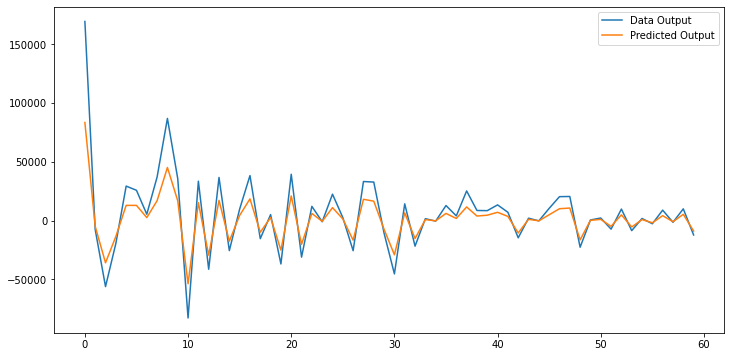

Loss between predicted output and actual output (Both Normalised) 0.043473461817548714


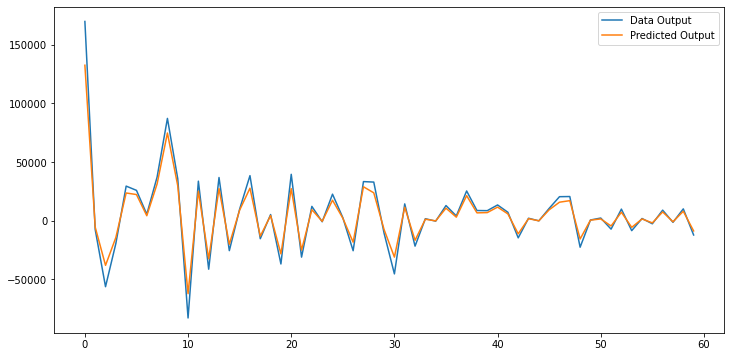

Loss between predicted output and actual output (Both Normalised) 0.05571680165690331


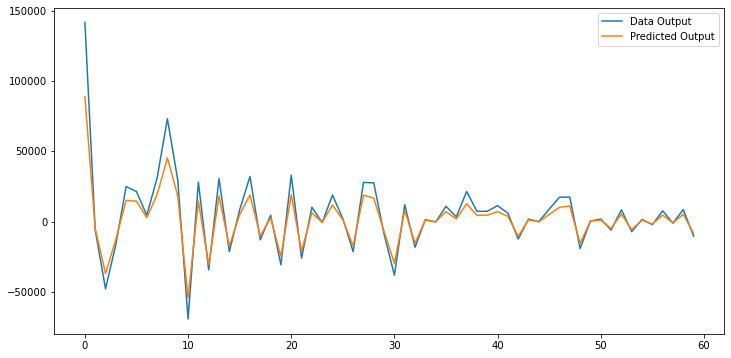

Loss between predicted output and actual output (Both Normalised) 0.09074213957605957


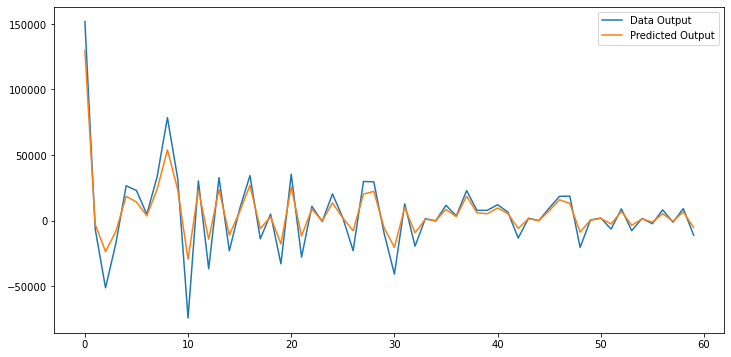

Loss between predicted output and actual output (Both Normalised) 0.0683258141604885


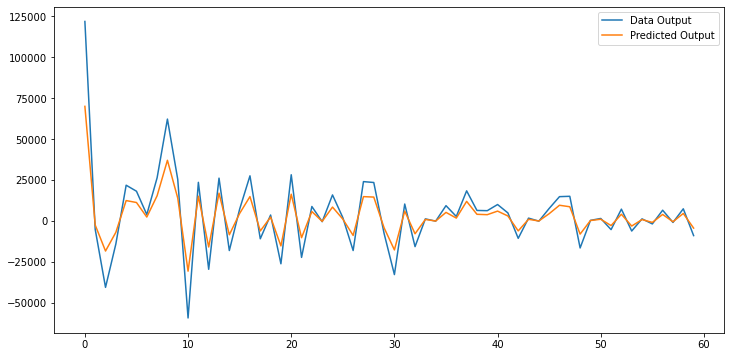

Loss between predicted output and actual output (Both Normalised) 0.036984672766386194


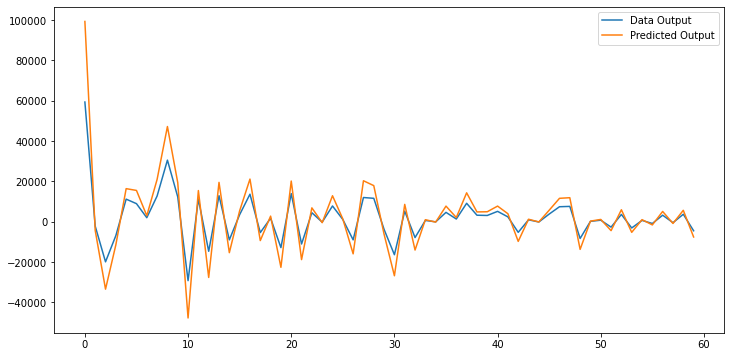

Loss between predicted output and actual output (Both Normalised) 0.00403995606409061


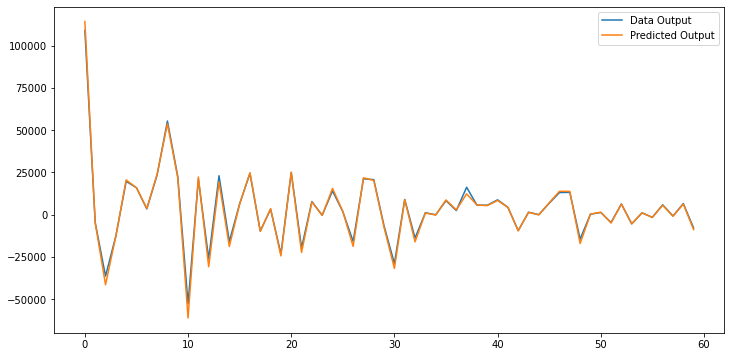

Loss between predicted output and actual output (Both Normalised) 0.019374538172271367


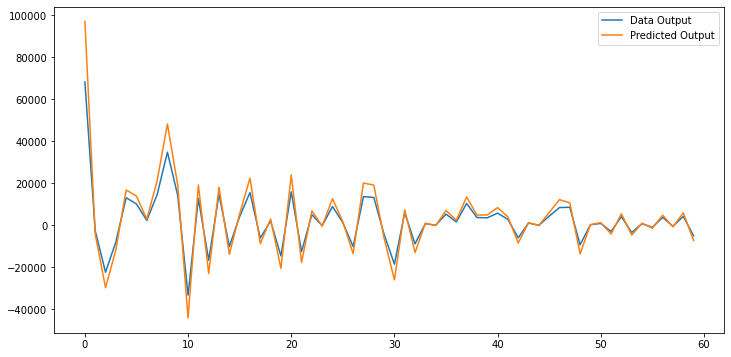

In [17]:
# Testing for a complete batch in the test dataset using the best model

model.load_state_dict(torch.load('geoid_model_best.pth'))
testing_criterion = nn.MSELoss()

test_input, test_output = next(iter(geoid_test_loader))
for i in range(batch_size):    
    test_index = i
    test_input_batch_sample = test_input[test_index]
    test_output_batch_sample = test_output[test_index]
    predicted_output = model(test_input_batch_sample)
    
    loss = testing_criterion(test_output_batch_sample, predicted_output)
    print("Loss between predicted output and actual output (Both Normalised)",loss.item())
    
    #print(scaler.inverse_transform([predicted_output.detach().numpy()])[0])
    
    plt.figure(figsize=(12, 6))

    plt.plot(scaler.inverse_transform([test_output_batch_sample.detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([predicted_output.detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()